## Семинар 6 "Segmentation"

ФИО: Костюшко Леонид Игоревич

https://drive.grand-challenge.org/

Top 45 Score- 0.8141

### Import

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
import torchvision
from torch.utils import data
from torchvision import transforms as tsf
import torchvision.transforms.functional as F

import scipy.misc

from pathlib import Path
import shutil

from PIL import Image
import skimage
from skimage import io
from skimage import transform
import PIL

from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from sklearn.model_selection import train_test_split
import sys
#import elasticdeform
import matplotlib.image as mpimg
import random

from torch.autograd import Variable
import imageio
import cv2
from skimage import exposure

from IPython.display import clear_output

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'

path_last = '/content/drive/My Drive/last_state_unet_up.pt'
path_best = '/content/drive/My Drive/best_state_unet_up.pt'


%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
use_cuda = True

### Load data

In [0]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

  
    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('/content/drive/My Drive/test_images/images')
t.save(test, TEST_PATH)
train_data = process('/content/drive/My Drive/training_images/images', "/content/drive/My Drive/training_1st_manual/1st_manual")

In [0]:
result_data = []
for i in tqdm(range(100)):
  result_data.extend(train_data)

100%|██████████| 100/100 [00:00<00:00, 167037.20it/s]


In [0]:
class DatasetCropped(Dataset):
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.to_pil = tsf.ToPILImage()
        self.to_black_white = tsf.Grayscale(num_output_channels=1)
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        
        img = self.to_pil(img)
        mask = self.to_pil(mask)
        
        #to black-white
        img = self.to_black_white(img)
        mask = self.to_black_white(mask)

        # histogram equalisation
        img = np.array(img)
        mask = np.array(mask)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        mask = clahe.apply(mask)
        
        # gamma
        img = exposure.adjust_gamma(img, 2.1)
        mask = exposure.adjust_gamma(mask, 2.1)

        

        # rotating and scaling
        # img = Image.fromarray(img)
        # mask = Image.fromarray(mask)

        # affine_params = torchvision.transforms.RandomAffine.get_params(degrees=(0, 359), translate=(0,0), scale_ranges=(1, 1),shears = (0, 5), img_size=(768,584))

        # img = tsf.functional.affine(img, angle=affine_params[0], translate=(0, 0), scale=1, shear = affine_params[3][0])
        # mask = tsf.functional.affine(mask, angle=affine_params[0], translate=(0, 0), scale=1, shear = affine_params[3][0])

        
        #smart cropping
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        i, j, h, w = torchvision.transforms.RandomCrop.get_params(img, output_size=(100, 100))
        img = torchvision.transforms.functional.crop(img, i, j, h, w)
        mask = torchvision.transforms.functional.crop(mask, i, j, h, w)
    
        
        
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
t_trans = tsf.Compose([
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5],std = [0.5])
]
)
s_trans = tsf.Compose([
    #tsf.Resize((768,584),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5],std = [0.5])
]
)
dataset = DatasetCropped(result_data,s_trans,t_trans)

In [0]:
lengths = [int(0.95*len(dataset)), int(0.05*len(dataset))]
train_val, test_val = random_split(dataset, lengths)
print("Train data length", len(train_val))
print("Test data length", len(test_val))

Train data length 1900
Test data length 100


In [0]:
train_dataloader = DataLoader(train_val, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_val, batch_size=4)

### Loss function

In [0]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

### Save model function

In [0]:
def save_checkpoint(state, is_best, path_l, path_b):
  t.save(state, path_l)
  if is_best:
    shutil.copyfile(path_l, path_b)

### Train function

In [0]:
dtype=t.FloatTensor
def train(network, epochs, loss, optimizer):
  
    train_loss_epochs = []
    test_loss_epochs = []
    min_test_loss = 100000.0

    try:   
      for epoch in range(epochs):
        model.train()
        losses = []

        for sample in train_dataloader:
          X = sample[0]
          X = X.type(dtype)
          y = sample[1]

          if use_cuda and t.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        
          
          optimizer.zero_grad()
          prediction = network(X)
    
          loss_batch = loss(prediction, y)
          losses.append(loss_batch.item())
          
          loss_batch.backward()
          optimizer.step()
  
        train_loss_epochs.append(np.mean(losses))
        
        

        model.eval()
        losses = []    

        with t.no_grad():
          for sample in test_dataloader:
            X = sample[0]
            X = X.type(dtype)
            y = sample[1]

            if use_cuda and t.cuda.is_available():
              X = X.cuda()
              y = y.cuda()

            prediction = network(X)
          
                
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.item())

          min_test_loss = min(min_test_loss, np.mean(losses))
          test_loss_epochs.append(np.mean(losses))


        #save model
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss': np.mean(losses),
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        if min_test_loss == np.mean(losses):
          save_checkpoint(checkpoint, True, path_last, path_best)
        else:
          save_checkpoint(checkpoint, False, path_last, path_best)

        #visualising loss
        clear_output(True)
        sys.stdout.write('\rEpoch {0}... (Train/Test) Dice: {1:.3f}/{2:.3f}'.format(
                    epoch, train_loss_epochs[-1], test_loss_epochs[-1]))

        plt.figure(figsize=(12, 5))
        plt.plot(train_loss_epochs, label='Train')
        plt.plot(test_loss_epochs, label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
       
    except KeyboardInterrupt:
        pass

### U-Net

In [0]:
from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
         #   nn.Dropout(p=0.2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
    
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = t.nn.functional.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

### Training

In [0]:
model = UNet(1, 1).cuda()
optimizer = t.optim.Adam(model.parameters(), lr=0.01)

In [0]:
#load state dict
checkpoint = t.load(path_last)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [0]:
print(checkpoint['epoch'],"  ", checkpoint['valid_loss'])

In [0]:
train(model, 100, soft_dice_loss, optimizer)

### ResU-Net

In [0]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv_res(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv_res, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x = x1.add(x2)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv_res(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv_res(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv_res(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
      #  print(x1.size())
       # print(x2.size())
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ResUNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
       # print(x4.size())
       # print(x5.size())
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [0]:
model_res = ResUNet(1, 1)

In [0]:
if use_cuda and t.cuda.is_available():
  model_res.cuda()

In [0]:
train(model_res, 15 , 0.03, soft_dice_loss)

RuntimeError: ignored

### Test

In [0]:
s_trans = tsf.Compose([
    #tsf.ToPILImage(),
 #   tsf.Grayscale(num_output_channels=1),
 #   tsf.Resize((512,512)),
    tsf.ToTensor(),
  #  tsf.Normalize(mean = [0.5],std = [0.5])
    #tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform

        self.to_pil = tsf.ToPILImage()
        self.to_black_white = tsf.Grayscale(num_output_channels=1)
       
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()

        img = self.to_pil(img)
        
        img = self.to_black_white(img)

        # histogram equalisation and gamma correction
        # img = np.array(img)
        
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # img = clahe.apply(img)
        
        #gamma
        # img = exposure.adjust_gamma(img, 1.7)

        
        # img = self.to_pil(img)

        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [0]:
os.makedirs("result")
!zip -r result.zip result

In [0]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
   # data = data.permute(2, 3, 1, 0).numpy()
   # data = np.squeeze(data, axis=3)
    
  #  data = skimage.color.rgb2gray(data)
    
   # data = t.from_numpy(data)
   # data = data.unsqueeze(0)
   # data = data.unsqueeze(0)

    #data = Variable(data)
    data = data.cuda()

    o = model(data)
    
    source_image = io.imread("/content/drive/My Drive/test_images/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    #tm = (tm > 0.5).astype(float)
    
    imageio.imwrite("/content/result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.6/dist-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


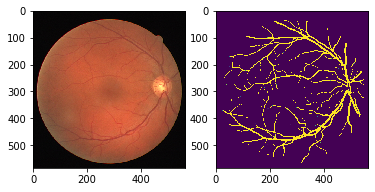

In [0]:
#for rgb
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
x = data[0].data.cpu().permute(1,2,0).numpy()
plt.imshow(x*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

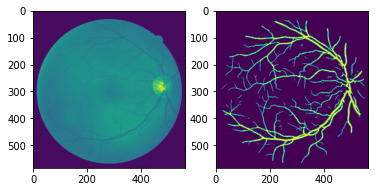

In [0]:
#for grayscale
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
x = data[0].data.cpu().permute(1,2,0).numpy()
x = np.squeeze(x, axis=2)
plt.imshow(x*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

In [0]:
!zip -r /content/result.zip  /content/result

updating: content/result/ (stored 0%)
updating: content/result/19.png (deflated 1%)
updating: content/result/5.png (deflated 1%)
updating: content/result/4.png (deflated 1%)
updating: content/result/13.png (deflated 1%)
updating: content/result/16.png (deflated 0%)
updating: content/result/15.png (deflated 0%)
updating: content/result/8.png (deflated 1%)
updating: content/result/3.png (deflated 1%)
updating: content/result/6.png (deflated 1%)
updating: content/result/17.png (deflated 1%)
updating: content/result/1.png (deflated 1%)
updating: content/result/18.png (deflated 1%)
updating: content/result/11.png (deflated 1%)
updating: content/result/10.png (deflated 0%)
updating: content/result/12.png (deflated 1%)
updating: content/result/7.png (deflated 1%)
updating: content/result/2.png (deflated 1%)
updating: content/result/20.png (deflated 1%)
updating: content/result/14.png (deflated 1%)
updating: content/result/9.png (deflated 1%)


In [0]:
from google.colab import files
files.download("/content/result.zip")